In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# Distribution of maximum for 1-D prior example
> Investigation into the distribution of the maximum for a 1-D toy example.

In [ ]:
#hide
from dolfin import *
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import matplotlib.cm as cm
# plt.rcParams['figure.figsize'] = (10,6)
# import required functions from oneDim
from statFEM.oneDim import mean_assembler, kernMat, cov_assembler, sample_gp
from scipy.stats import linregress
from scipy import integrate
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

Let's first import the `wass` function created in the sub-module `maxDist`.

In [ ]:
from statFEM.maxDist import wass

# Sampling from true maxiumum distribution in 1D

We will be interested in the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>. To obtain a sample for the maximum from the true prior we must first sample trajectories from the true prior.

In [ ]:
# set up true mean
def m_u(x):
    return 0.5*x*(1-x)

In [ ]:
# set up kernel functions for forcing f
# l_f = 0.4
l_f = 0.01
σ_f = 0.1
# σ_f = 1

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

In [ ]:
# set up true cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

In [ ]:
%%time
n_sim = 1000
grid = np.linspace(0,1,100)
np.random.seed(235)
u_sim = sample_gp(n_sim, m_u, c_u, grid, par = True, trans = False, tol = 1e-8)

CPU times: user 871 ms, sys: 151 ms, total: 1.02 s
Wall time: 1min 3s


We now plot the sampled trajectories from the true prior.

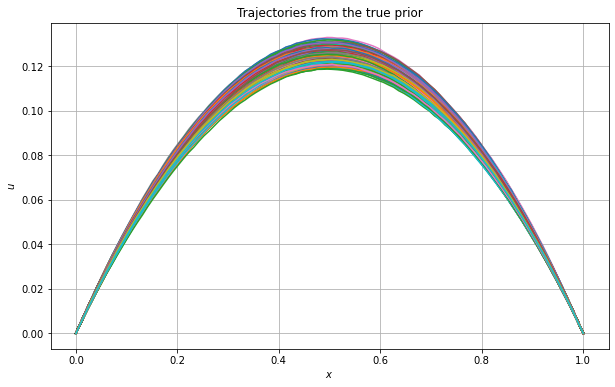

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from the true prior')
plt.grid()
plt.show()

> Note: The maximum is __not__ always located at $x=0.5$. We will demonstrate this by plotting the $\operatorname{argmax}$ for each simulated curve below.

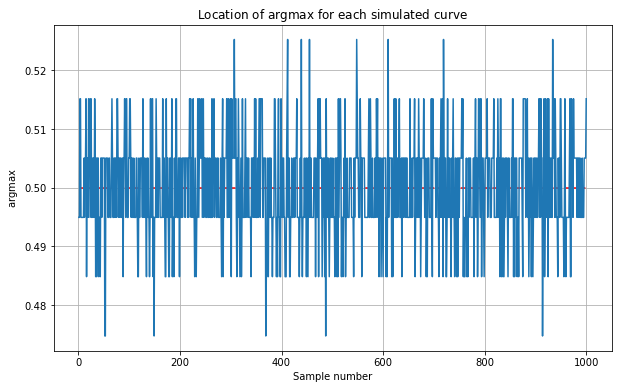

In [ ]:
#hide_input
plt.plot(np.arange(1,n_sim + 1),grid[u_sim.argmax(axis=0)])
plt.hlines(0.5,1,n_sim,colors='red',linestyles='dashed')
plt.grid()
plt.xlabel('Sample number')
plt.ylabel('$\operatorname{argmax}$')
plt.title('Location of $\operatorname{argmax}$ for each simulated curve')
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_true` for future use. We plot the histogram for these maximum values.

In [ ]:
max_true = u_sim.max(axis=0)

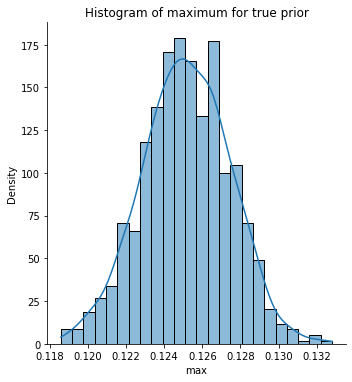

In [ ]:
#hide_input
sns.displot(max_true,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histogram of maximum for true prior')
plt.show()

# Sampling from statFEM prior maxiumum distribution in 1D

We now create a function to utilise FEniCS to draw trajectories from the statFEM prior.

In [ ]:
# create statFEM sampler function
def statFEM_sampler(n_sim, grid, h, f_bar, k_f, par = False, trans = True, tol=1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))

    # get statFEM mean function
    μ_func = mean_assembler(h, f_bar)
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM cov mat on grid
    Σ = cov_assembler(J, k_f, grid, parallel=par, translation_inv=trans)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

Let's test this function out by using it to obtain samples from the statFEM prior for a particular value of $h$.

In [ ]:
h = 0.1
f_bar = Constant(1.0)
np.random.seed(2123)
u_sim_statFEM = statFEM_sampler(n_sim, grid, h, f_bar, k_f)

Let's plot the above trajectories.

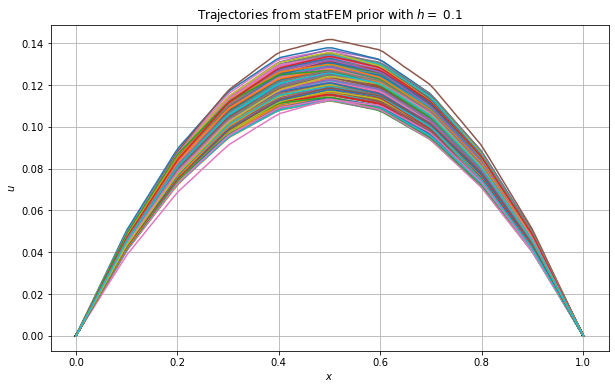

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim_statFEM)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from statFEM prior with $h = $ %0.1f' % h)
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_statFEM` for future use. We then plot the histograms for these maximum values together with those from the true prior.

In [ ]:
max_statFEM = u_sim_statFEM.max(axis=0)

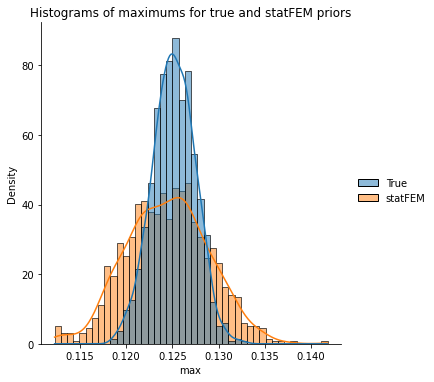

In [ ]:
#hide_input
max_data = pd.DataFrame(data={'True': max_true, 'statFEM': max_statFEM})
sns.displot(max_data,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histograms of maximums for true and statFEM priors')
plt.show()

Our `wass` function requires the number of bins to be specified. Let's investigate how varying this parameter affects the computed distance between the true maximums and our statFEM maximums.

In [ ]:
n_bins = np.arange(10,200,10)
wass_bin_dat = [wass(max_true,max_statFEM,n) for n in n_bins]

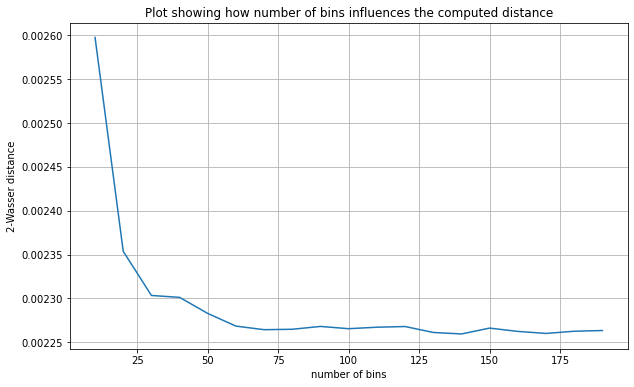

In [ ]:
#hide_input
plt.plot(n_bins,wass_bin_dat)
plt.grid()
plt.xlabel('number of bins')
plt.ylabel('2-Wasser distance')
plt.title('Plot showing how number of bins influences the computed distance')
plt.show()

From the plot above we see that the distance flattens after around $50$ bins. We choose to take `n_bins=100` for the rest of this example.

We now set up a range of $h$-values to use for the statFEM prior.

In [ ]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
np.round(h_range,2)

array([0.25, 0.2 , 0.17, 0.14, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02])

We now loop over these $h$-values, and for each value we simulate maximums from the statFEM prior and then compute the 2-Wasserstein distance between these maximums and those from the true prior.

In [ ]:
%%time
errors = []
###################
n_bins = 100
##################
np.random.seed(3252)
for h in tqdm(h_range):
    # sample trajectories from statFEM prior for current h value
    sim = statFEM_sampler(n_sim,grid,h,f_bar,k_f)
    # get max
    max_sim = sim.max(axis=0)
    # compute error
    error = wass(max_true,max_sim,n_bins)
    # append to errors
    errors.append(error)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1.62 s, sys: 3.71 s, total: 5.33 s
Wall time: 776 ms


Let's now plot these errors against $h$.

In [ ]:
#hide
errors = np.array(errors)

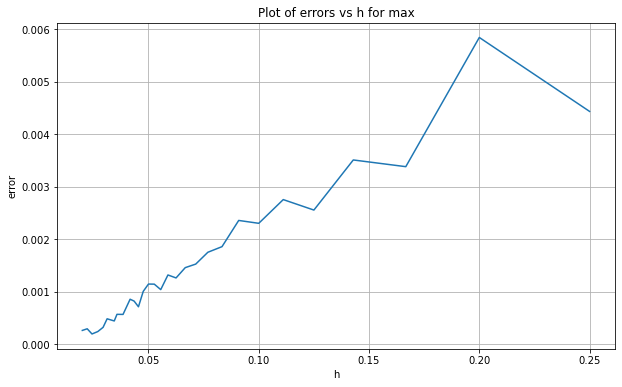

In [ ]:
#hide_input
plt.plot(h_range,errors)
plt.grid()
plt.xlabel('h')
plt.ylabel('error')
plt.title('Plot of errors vs h for max')
plt.show()

We see that as $h$ decreases so too does the distance/error. Let's investigate the rate by plotting this data in log-log space and then estimating the slope of the line of best fit.

slope: 1.346020    intercept: -3.028927    r value: 0.971118     p value: 0.000000


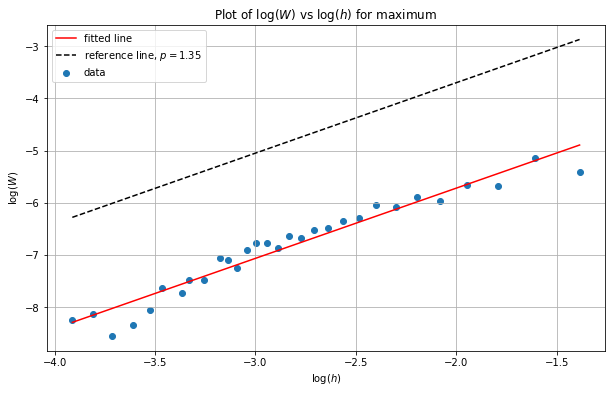

In [ ]:
#hide_input
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
# plt.plot(x,2+2*x,'--',c='black',label='reference line, $p=2$')
plt.plot(x,-1+1.35*x,'--',c='black',label='reference line, $p=1.35$')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$ for maximum')
plt.savefig('1D_max_prior_results.png',dpi=300,bbox_inches='tight',facecolor="w")
plt.show()

We can see from the above plot that the slope is around $1$ - this differs from our theory showing the results for the $\max$ are out of the remit of our theory.